# Importing Libraries

In [2]:
# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Date Manipulation
from datetime import datetime

# Time Series Analysis and Forecasting Models
from statsmodels.tsa.stattools import adfuller  # ADF Test for stationarity
from statsmodels.tsa.arima.model import ARIMA  # ARIMA Model
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA Model
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # Holt-Winters Model

# Automatic Model Selection
from pmdarima import auto_arima  # Auto ARIMA model selection

# Prophet Model
from prophet import Prophet

# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# Disable warnings to keep output clean
import warnings
warnings.filterwarnings("ignore")

# Setting visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Data Exploration

In [4]:
# Load the dataset
df = pd.read_csv('Electricity Consumption.csv')

In [5]:
df.head(3)

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [7]:
# Check for missing values in the dataset
print("Missing values in the dataset:")
df.isnull().sum()

Missing values in the dataset:


DATE                            0
Electricty_Consumption_in_TW    0
dtype: int64

In [8]:
# Check summary statistics for numerical columns
print("Summary statistics for numerical columns:")
df.describe()

Summary statistics for numerical columns:


,Electricty_Consumption_in_TW
count,561.000000
mean,76.681764
std,22.756474
min,33.510700
25%,55.919700
50%,78.417000
75%,93.840600
max,123.216300


In [9]:
# Convert the 'DATE' column to datetime format 
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index for time series analysis
df.set_index('DATE', inplace=True)

# Check the dataset after setting 'DATE' as index
print("Dataset after setting 'DATE' as index:")
df.head()

Dataset after setting 'DATE' as index:


,Electricty_Consumption_in_TW
DATE,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107


### Electricity Consumption over Time

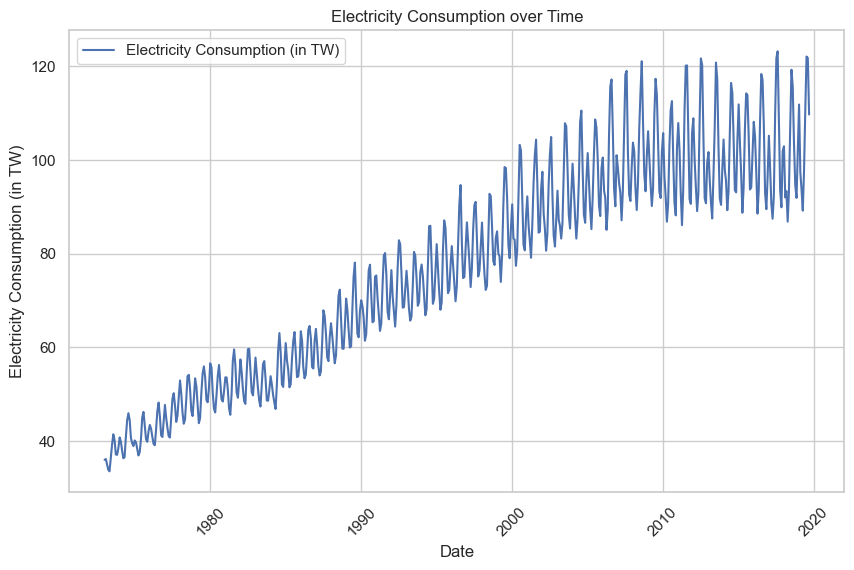

In [11]:
# Plot the electricity consumption over time
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Electricty_Consumption_in_TW'], label='Electricity Consumption (in TW)')
plt.title('Electricity Consumption over Time')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (in TW)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

##### Insights
- Upward Trend: Electricity consumption has steadily increased over the decades, reflecting growth in population, industrialization, and technological advancements.
- Seasonal Variations: Consumption shows regular fluctuations within each year, with higher usage during winter and summer months, likely driven by heating and cooling needs.

# ADF Test (Augmented Dickey-Fuller)
### Checking for Stationarity

In [14]:
def adf_test(series):
    # Perform the Augmented Dickey-Fuller test
    adf_result = adfuller(series)
    
    # Extract and print the results
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]
    
    # Display results
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"\t{key}: {value}")
    
    # Interpretation of results
    if p_value < 0.05:
        print("\nThe time series is likely stationary (reject the null hypothesis).")
    else:
        print("\nThe time series is likely non-stationary (fail to reject the null hypothesis).")

# Call the function on the original series
adf_test(df['Electricty_Consumption_in_TW'])


ADF Statistic: -1.7405933729832284
p-value: 0.41032816044687603
Critical Values:
	1%: -3.442405720052601
	5%: -2.866857804790472
	10%: -2.5696022094099824

The time series is likely non-stationary (fail to reject the null hypothesis).


# Decomposing the Time Series (Trend, Seasonality, Residuals)

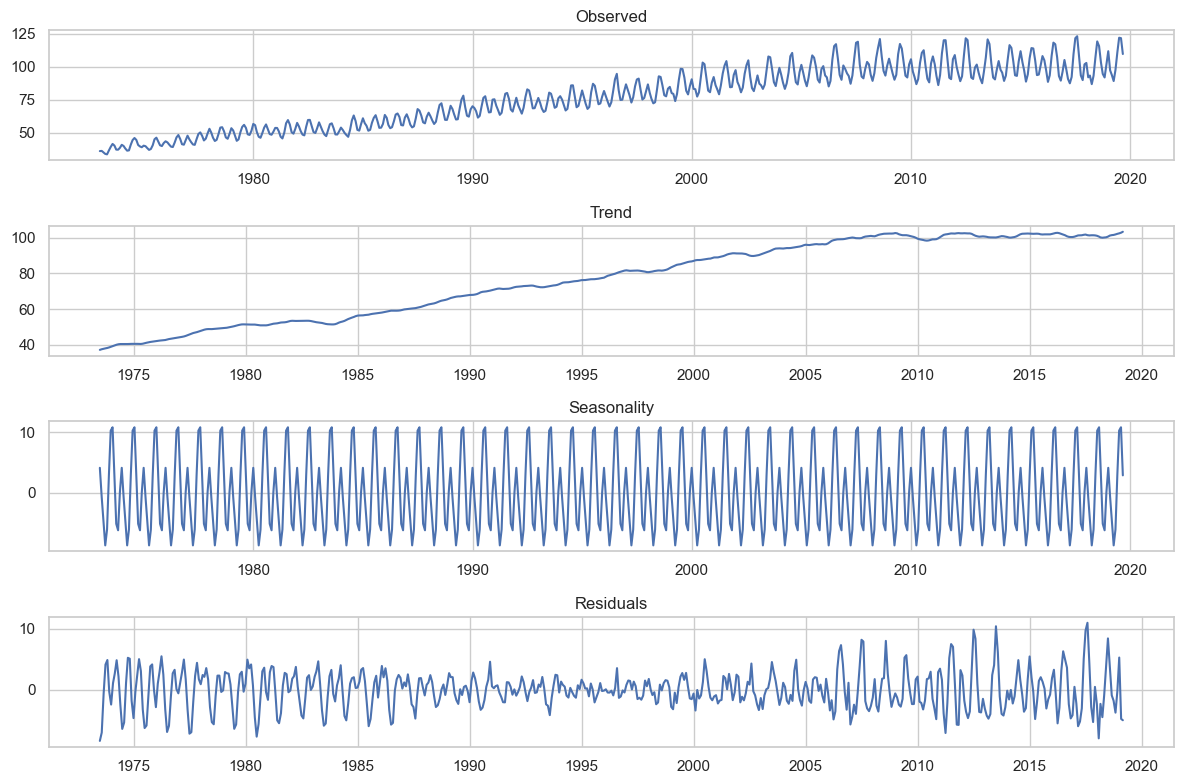

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df['Electricty_Consumption_in_TW'], model='additive', period=12)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()


# Differencing After Decomposition

In [27]:
# Apply first-order differencing
df['First_Difference'] = df['Electricty_Consumption_in_TW'].diff().dropna()

# Apply second-order differencing on the first differenced data
df['Second_Difference'] = df['First_Difference'].diff().dropna()

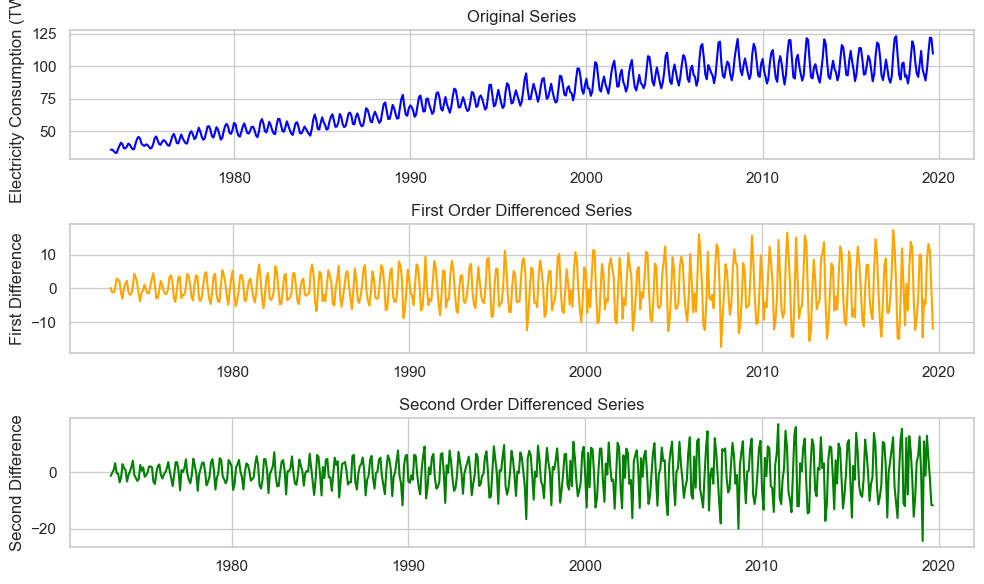

In [29]:
# Plotting the Original, First Differenced, and Second Differenced series
plt.figure(figsize=(10, 6))

# Original series
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Electricty_Consumption_in_TW'], color='blue')
plt.title('Original Series')
plt.ylabel('Electricity Consumption (TW)')

# First differenced series
plt.subplot(3, 1, 2)
plt.plot(df.index, df['First_Difference'], color='orange')
plt.title('First Order Differenced Series')
plt.ylabel('First Difference')

# Second differenced series
plt.subplot(3, 1, 3)
plt.plot(df.index, df['Second_Difference'], color='green')
plt.title('Second Order Differenced Series')
plt.ylabel('Second Difference')

plt.tight_layout()
plt.show()

## Re-test for Stationarity

In [31]:
# Check for stationarity again on the second-differenced series
adf_test(df['Second_Difference'].dropna())

ADF Statistic: -12.005651618913824
p-value: 3.2686891274065263e-22
Critical Values:
	1%: -3.442517884424376
	5%: -2.8669071815780116
	10%: -2.5696285219478736

The time series is likely stationary (reject the null hypothesis).


## Checking for Outliers

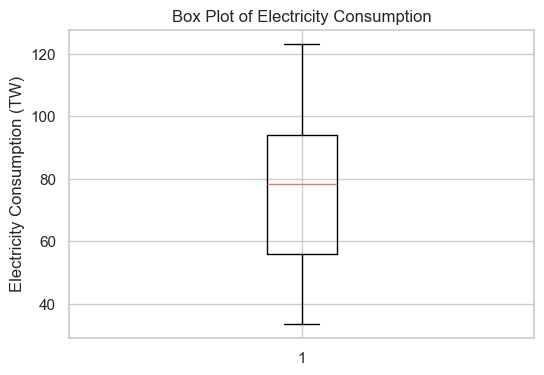

In [37]:
# Box plot for identifying outliers
plt.figure(figsize=(6, 4))
plt.boxplot(df['Electricty_Consumption_in_TW'])
plt.title('Box Plot of Electricity Consumption')
plt.ylabel('Electricity Consumption (TW)')
plt.show()

In [39]:
# Detect Outliers Using the Z-score

# Calculate Z-scores
df['Z_Score'] = (df['Electricty_Consumption_in_TW'] - df['Electricty_Consumption_in_TW'].mean()) / df['Electricty_Consumption_in_TW'].std()

# Identify outliers
outliers = df[np.abs(df['Z_Score']) > 3]
print("Outliers:")
print(outliers[['Electricty_Consumption_in_TW', 'Z_Score']])

Outliers:
Empty DataFrame
Columns: [Electricty_Consumption_in_TW, Z_Score]
Index: []


##### No outliers were detected

# Modeling Techniques

##### We will try ARIMA, SARIMA, ETS, and Dart Library Models (AutoARIMA, ETS, Prophet)

## Step 1: Model Creation and Parameter Tuning

### 1. ARIMA Model 

In [47]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model with initial parameters (p=1, d=1, q=1)
arima_model = ARIMA(df['Second_Difference'].dropna(), order=(1, 1, 1))
arima_results = arima_model.fit()

# Print summary of ARIMA model
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:      Second_Difference   No. Observations:                  559
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1847.140
Date:                Sat, 09 Nov 2024   AIC                           3700.279
Time:                        23:03:49   BIC                           3713.252
Sample:                    03-01-1973   HQIC                          3705.346
                         - 09-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2227      0.054      4.111      0.000       0.117       0.329
ma.L1         -0.9999      2.345     -0.426      0.670      -5.596       3.596
sigma2        43.4802    101.692      0.428      0.6

### 2 SARIMA Model (Seasonal ARIMA)

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA model with parameters (p=1, d=1, q=1) for non-seasonal and (P=1, D=1, Q=1, S=12) for seasonal
sarima_model = SARIMAX(df['Second_Difference'].dropna(), order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()

# Print summary of SARIMA model
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  Second_Difference   No. Observations:                  559
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1307.019
Date:                            Sat, 09 Nov 2024   AIC                           2624.039
Time:                                    23:04:06   BIC                           2645.552
Sample:                                03-01-1973   HQIC                          2632.448
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4437      0.036    -12.241      0.000      -0.515      -0.373
ma.L1         -0.9999      3.207   

### 3. ETS Model (Exponential Smoothing)

In [53]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ETS model with additive trend and seasonality
ets_model = ExponentialSmoothing(df['Electricty_Consumption_in_TW'], trend='add', seasonal='add', seasonal_periods=12)
ets_results = ets_model.fit()

# Print ETS model summary
print(ets_results.summary())

                           ExponentialSmoothing Model Results                           
Dep. Variable:     Electricty_Consumption_in_TW   No. Observations:                  561
Model:                     ExponentialSmoothing   SSE                           2137.742
Optimized:                                 True   AIC                            782.497
Trend:                                 Additive   BIC                            851.773
Seasonal:                              Additive   AICC                           783.759
Seasonal Periods:                            12   Date:                 Sat, 09 Nov 2024
Box-Cox:                                  False   Time:                         23:04:17
Box-Cox Coeff.:                            None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.509

### 4. Darts Library Models

In [67]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing, AutoARIMA, Prophet

# Reset index to make 'DATE' a column
df_reset = df.reset_index()

# Convert data to Darts TimeSeries format
series = TimeSeries.from_dataframe(df_reset, time_col='DATE', value_cols='Electricty_Consumption_in_TW')

# Exponential Smoothing
darts_ets_model = ExponentialSmoothing()
darts_ets_model.fit(series)
print("Darts Exponential Smoothing model created successfully.")

# AutoARIMA
darts_arima_model = AutoARIMA()
darts_arima_model.fit(series)
print("Darts AutoARIMA model created successfully.")

# Prophet within Darts
darts_prophet_model = Prophet()
darts_prophet_model.fit(series)
print("Darts Prophet model created successfully.")

Darts Exponential Smoothing model created successfully.
Darts AutoARIMA model created successfully.


23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:22 - cmdstanpy - INFO - Chain [1] done processing


Darts Prophet model created successfully.


## Step 2: Train-Test Split and Cross-Validation

In [70]:
# Split data into training and test sets
train_size = int(len(series) * 0.8)
train_series, test_series = series[:train_size], series[train_size:]

print(f"Train size: {train_size}, Test size: {len(series) - train_size}")
print("Train-test split completed.")

Train size: 448, Test size: 113
Train-test split completed.


## Step 3: Model Validation Metrics

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Calculate RMSE, MAPE, and RMSPE for ARIMA
def calculate_metrics(true_values, forecast_values):
    rmse = np.sqrt(mean_squared_error(true_values, forecast_values))
    mape = mean_absolute_percentage_error(true_values, forecast_values) * 100
    rmspe = np.sqrt(np.mean(np.square((true_values - forecast_values) / true_values))) * 100
    return rmse, mape, rmspe

### 1. ARIMA Model Validation

In [90]:
# Forecast with ARIMA 
arima_forecast = arima_results.forecast(steps=len(test_series))

# Modify the forecast and test_series to be 1-dimensional (flattening if needed)
arima_forecast_1d = np.array(arima_forecast).flatten()  # Flatten if necessary
test_series_1d = np.array(test_series.values()).flatten()  # Flatten the test series

# Now calculate the metrics
arima_rmse, arima_mape, arima_rmspe = calculate_metrics(test_series_1d, arima_forecast_1d)

print(f"ARIMA - RMSE: {arima_rmse}, MAPE: {arima_mape}, RMSPE: {arima_rmspe}")

ARIMA - RMSE: 102.21003719954047, MAPE: 100.06007327141577, RMSPE: 100.06044921953065


### 2. SARIMA Model Validation

In [94]:
# Forecast with SARIMA 
sarima_forecast = sarima_results.forecast(steps=len(test_series))
sarima_forecast_1d = np.array(sarima_forecast).flatten()

# Calculate the metrics
sarima_rmse, sarima_mape, sarima_rmspe = calculate_metrics(test_series_1d, sarima_forecast_1d)

print(f"SARIMA - RMSE: {sarima_rmse}, MAPE: {sarima_mape}, RMSPE: {sarima_rmspe}")

SARIMA - RMSE: 102.20300374617233, MAPE: 100.2793022637215, RMSPE: 100.68824764125239


### 3. ETS Model (Regular Exponential Smoothing)

In [96]:
# Forecast with ETS
ets_forecast = ets_results.forecast(len(test_series))
ets_forecast_1d = np.array(ets_forecast).flatten()

# Calculate RMSE, MAPE, and RMSPE for ETS
ets_rmse, ets_mape, ets_rmspe = calculate_metrics(test_series_1d, ets_forecast_1d)

print(f"ETS (Regular) - RMSE: {ets_rmse}, MAPE: {ets_mape}, RMSPE: {ets_rmspe}")

ETS (Regular) - RMSE: 17.857072658760806, MAPE: 14.176820166367998, RMSPE: 18.91323987463117


### 4. AutoARIMA (Darts)

In [102]:
# Forecast with AutoARIMA
darts_arima_forecast = darts_arima_model.predict(len(test_series))
darts_arima_forecast_1d = darts_arima_forecast.values().flatten()

# Calculate RMSE, MAPE, and RMSPE for AutoARIMA
darts_arima_rmse, darts_arima_mape, darts_arima_rmspe = calculate_metrics(test_series_1d, darts_arima_forecast_1d)

print(f"AutoARIMA (Darts) - RMSE: {darts_arima_rmse}, MAPE: {darts_arima_mape}, RMSPE: {darts_arima_rmspe}")


AutoARIMA (Darts) - RMSE: 14.370252189223095, MAPE: 12.281180074581163, RMSPE: 15.144346508889706


### 5. ETS (Darts)

In [104]:
# Forecast with Darts ETS
darts_ets_forecast = darts_ets_model.predict(len(test_series))
darts_ets_forecast_1d = darts_ets_forecast.values().flatten()

# Calculate RMSE, MAPE, and RMSPE for Darts ETS
darts_ets_rmse, darts_ets_mape, darts_ets_rmspe = calculate_metrics(test_series_1d, darts_ets_forecast_1d)

print(f"ETS (Darts) - RMSE: {darts_ets_rmse}, MAPE: {darts_ets_mape}, RMSPE: {darts_ets_rmspe}")


ETS (Darts) - RMSE: 17.857072658760806, MAPE: 14.176820166367998, RMSPE: 18.91323987463117


### 6. Prophet (Darts)

In [106]:
# Forecast with Darts Prophet
darts_prophet_forecast = darts_prophet_model.predict(len(test_series))
darts_prophet_forecast_1d = darts_prophet_forecast.values().flatten()

# Calculate RMSE, MAPE, and RMSPE for Darts Prophet
darts_prophet_rmse, darts_prophet_mape, darts_prophet_rmspe = calculate_metrics(test_series_1d, darts_prophet_forecast_1d)

print(f"Prophet (Darts) - RMSE: {darts_prophet_rmse}, MAPE: {darts_prophet_mape}, RMSPE: {darts_prophet_rmspe}")


Prophet (Darts) - RMSE: 11.441498291504532, MAPE: 9.432146711350997, RMSPE: 11.583131514574307


## Step 4: Model Comparison

In [119]:
# Create a DataFrame to compare the metrics
model_comparison = {
    'Model': ['ARIMA', 'SARIMA', 'ETS (Regular)', 'AutoARIMA (Darts)', 'ETS (Darts)', 'Prophet (Darts)'],
    'RMSE': [arima_rmse, sarima_rmse, ets_rmse, darts_arima_rmse, darts_ets_rmse, darts_prophet_rmse],
    'MAPE (%)': [arima_mape, sarima_mape, ets_mape, darts_arima_mape, darts_ets_mape, darts_prophet_mape],
    'RMSPE (%)': [arima_rmspe, sarima_rmspe, ets_rmspe, darts_arima_rmspe, darts_ets_rmspe, darts_prophet_rmspe]
}

# Convert the model comparison to a DataFrame for easy viewing
comparison_df = pd.DataFrame(model_comparison)
comparison_df


,Model,RMSE,MAPE (%),RMSPE (%)
0,ARIMA,102.210037,100.060073,100.060449
1,SARIMA,102.203004,100.279302,100.688248
2,ETS (Regular),17.857073,14.176820,18.913240
3,AutoARIMA (Darts),14.370252,12.281180,15.144347
4,ETS (Darts),17.857073,14.176820,18.913240
5,Prophet (Darts),11.441498,9.432147,11.583132


## Step 5: Forecasting

Forecasted demand for the next 24 months (1-2 years):
      Month  Forecasted Demand (in TW)
0   2019-10                  97.349955
1   2019-11                  96.187620
2   2019-12                 102.632975
3   2020-01                 106.691763
4   2020-02                 102.056068
5   2020-03                  98.340455
6   2020-04                  94.275050
7   2020-05                  96.659139
8   2020-06                 105.126285
9   2020-07                 112.760822
10  2020-08                 114.086589
11  2020-09                 105.581176
12  2020-10                  97.463224
13  2020-11                  96.507218
14  2020-12                 102.673258
15  2021-01                 106.509767
16  2021-02                 101.755165
17  2021-03                  98.382272
18  2021-04                  94.204904
19  2021-05                  96.780735
20  2021-06                 105.570102
21  2021-07                 113.136999
22  2021-08                 113.954908
23  2021-0

<Axes: xlabel='DATE'>

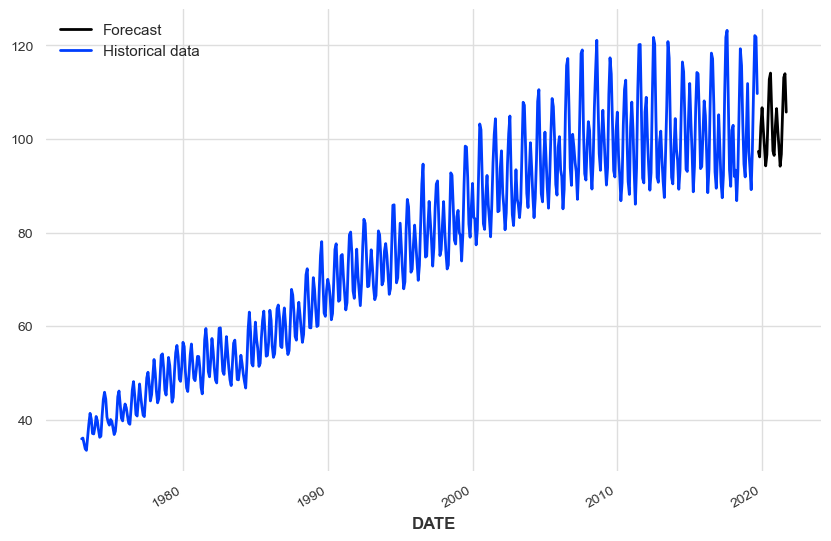

In [127]:
# Forecasting the next 1-2 years (for monthly data)
# 12 months per year, so for 2 years, it's 24 months
forecast_period = 24  

# Generate forecast
darts_prophet_forecast = darts_prophet_model.predict(forecast_period)

# Flatten the forecast to get a 1D array of values
darts_prophet_forecast_1d = darts_prophet_forecast.values().flatten()

# Generate month labels for the forecast period (starting from the next month)
months = pd.date_range(start=series.time_index[-1] + pd.DateOffset(months=1), periods=forecast_period, freq='MS').strftime('%Y-%m')

# Create a DataFrame to display the forecast in table format
forecast_table = pd.DataFrame({
    'Month': months,
    'Forecasted Demand (in TW)': darts_prophet_forecast_1d
})

# Output the forecasted demand table
print(f"Forecasted demand for the next {forecast_period} months (1-2 years):")
print(forecast_table)

# Plot the forecast
darts_prophet_forecast.plot(label='Forecast')
series.plot(label='Historical data')


## Step 6: Model Selection and Justification (Darts Prophet)

#### 1. Performance:
- RMSE: 11.44
- MAPE: 9.43%
- RMSPE: 11.58%
- Prophet (Darts) outperforms all other models in terms of these key metrics, indicating better forecast accuracy.

#### 2. Reason for Superior Performance:
- Seasonality Handling: Effectively captures daily, weekly, and yearly seasonality, which is crucial for electricity demand forecasting.
- Trend Capturing: Accurately models both linear and non-linear trends over time.
- Missing Data & Outliers: Robust to missing data or outliers, ensuring stable performance even in the presence of irregularities.

#### 3. Advantages:
- Accuracy: Lower RMSE, MAPE, and RMSPE compared to other models, showing superior forecast precision.
- Robustness: Handles missing values and outliers well, which is essential for real-world data.
- Seasonality and Trend Handling: Proven ability to capture complex seasonal patterns and long-term trends, making it ideal for long-term forecasting.
- Scalability: Easily adaptable to larger datasets and can be applied to future forecasting needs, ensuring scalability for long-term use.

#### 4. Conclusion:
- Best Overall Performance: Prophet (Darts) delivers the most reliable and accurate forecasts in this case.
- Future-Proof: Scalable and adaptable to different business needs, making it the best choice for this forecasting problem.